<a href="https://colab.research.google.com/github/akhil1729/Python-Projects/blob/main/602_Week_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble

In [ ]:
from google.colab import drive
drive.mount("/content/drive")
!mkdir -p datashim
!cp /content/drive/Shareddrives/DS602-F22/Data/data602.py ./datashim
from datashim import data602

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

1. **Custom transformer** Construct a custom data transformer that transforms a vector of `datetime` objects into a matrix comprising the following four columns:

* The sine and cosine components of the time of day on the unit circle, such that $\theta=0=2\pi$ represents midnight.
* The sine and cosine components of the day of the year on the unit circle, such that $\theta=0=2\pi$ represents January 1.

The following functions may be useful

In [ ]:
from datetime import datetime, timedelta
import calendar
#The following functions may be useful
@np.vectorize
def time_of_year_fraction(dt : datetime) -> float:
  """
  Returns the fraction of the calendar year (in [0, 1)) that has elapsed
  for a given datetime, as of the start of the calendar day.
  """
  dayofyear = dt.timetuple().tm_yday
  daysinyear = 365 + calendar.isleap(dt.year)
  return (dayofyear - 1)/daysinyear

@np.vectorize
def time_of_day_fraction(dt : datetime) -> float:
  """
  Returns the fraction of the day (in [0, 1)) that has elapsed
  for a given datetime.  Result is accurate to the minute level.
  """
  return (dt.hour * 60 + dt.minute)/(60 * 24)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted

# Custom Transformer
class DateTransformer(BaseEstimator, TransformerMixin):
    """
    This is a Customized transformer for converting datetime objects into time and day of year components.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        """
        This method does not need to learn parameters from the data, so it is left empty.
        """
        return self

    def transform(self, X):
        """
        Transforms a vector of datetime objects into a matrix with four columns.

        Columns:
            - sin_time_of_day: Sine of the time of day on the unit circle.
            - cos_time_of_day: Cosine of the time of day on the unit circle.
            - sin_time_of_year: Sine of the day of the year on the unit circle.
            - cos_time_of_year: Cosine of the day of the year on the unit circle.
        """

        # Ensure X is a numpy array
        X = np.array(X)

        # Validate input types
        if not np.all(np.vectorize(lambda x: isinstance(x, datetime))(X)):
            raise ValueError("Input must contain only datetime objects")

        # Calculate time of day and time of year fractions
        tod_fractions = np.vectorize(time_of_day_fraction)(X)
        toy_fractions = np.vectorize(time_of_year_fraction)(X)

        # Calculate sine and cosine components
        sine_tod = np.sin(2 * np.pi * tod_fractions)
        cosine_tod = np.cos(2 * np.pi * tod_fractions)
        sine_toy = np.sin(2 * np.pi * toy_fractions)
        cosine_toy = np.cos(2 * np.pi * toy_fractions)

        # Combine into a matrix
        X_transformed = np.column_stack([sine_tod, cosine_tod, sine_toy, cosine_toy])

        return X_transformed

The DataTransformer we created take the date column in the dataset as input and then calculates the time of day and time of year fractions for each datetime object using vectorized versions of the time_of_day_fraction and time_of_year_fraction functions, computes the sine and cosine components for both time of day and time of year using NumPy's vectorized operations and Finally, combines the sine and cosine components into a matrix with four columns and returns the transformed data.

**Problem 2: Data Transformation**

In week 3, problem 2, you prepared a matrix to predict the temperature from the following predictors:

* The non-temperature fields from the observation
* The temperature recorded in the prior observation

Suppose that as you train machine learning algorithms using this matrix, you find that training performs poorly.  You hypothesize that you could improve performance by adding additional features representing the proportion of the day and year that have elapsed
at the time each observation was taken.

Update your solution to Week 3, Problem 2 (or use the posted solution), together with the encoder you developed for Problem 1, to include these additional features.

The posted solution is below, except that the date column is kept.  Update the ColumnTransformer to transform the date column using the transformer developed for Problem 1.

In [ ]:
wdf = data602.read_weather()
for col in ['wnd_speed', 'tmp_meas', 'precip']:
  wdf[col] = wdf[col].interpolate()
wdf['cloudcover'] = wdf['cloudcover'].ffill()
wdf["prior_tmp_meas"] = wdf["tmp_meas"].shift(1)
wdf = wdf.iloc[1:, :]
y = wdf.pop('tmp_meas')

Update the column transformer to properly transform the date column using your transformer above

In [ ]:
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import (RobustScaler, MinMaxScaler,
                                   MaxAbsScaler, QuantileTransformer,
                                   FunctionTransformer)
from scipy.sparse import csc_matrix

ct = make_column_transformer(
      (
          RobustScaler(),
          ["wnd_speed", "prior_tmp_meas", "precip"]
      ),
      (
          MinMaxScaler(),
          ["cloudcover", "precip_intensity"]
      ),
      (
        DateTransformer(),  # Used the DateTransformer which was created above here
        ["date"]
      ),
      remainder="passthrough"
    )


#apply the transformation
Xt = ct.fit_transform(wdf)
display(Xt)
print("Number of rows:", Xt.shape[0])

array([[ 0.19230769, -0.48447205,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.19230769, -0.55279503,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -0.51552795,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.38461538,  0.72670807,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.38461538,  0.68944099,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.19230769,  0.58385093,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Number of rows: 67202


As we are filling the missing values in the dataset either by interpolation or forward fill as per the column type we will be having consident data for tranformation.In this code **RobustScaler** is used for wnd_speed and prior_tmp_meas to handle potential outliers. **MinMaxScaler** is used for cloudcover and precip_intensity to scale them to a range between 0 and 1. **DateTransformer** which we have created above is used for the date column to extract time-based features (sine and cosine components of time of day and time of year) and
**passthrough** is used for the remaining columns, leaving them as they are.

**Problem 3: Validation**

Partition the dataset from Problem 3 into three separate datasets: Test (25\% of records), Validation (15\% of records) and Training (60\% of records).

In [ ]:
from sklearn.model_selection import train_test_split
X = wdf
total_records = len(X)
print(f"Total number of records: {total_records}")
# Step 1: Divide into 75% training/validation and 25% test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

#Step 2: Divide the training and validation set into 15% validation and 60% training.
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, random_state=42)

# Let's print the size of total data size, training dataset size, validation dataset size and test dataset size
print(f"Training dataset size: {len(X_train)}")
print(f"Validation dataset size: {len(X_val)}")
print(f"Test dataset size: {len(X_test)}")

Total number of records: 67202
Training dataset size: 40320
Validation dataset size: 10081
Test dataset size: 16801


This code splits the dataset into training, validation, and test sets . The train_test_split function first divides the entire dataset (X, y) into two parts: i.e,

**1.** 75% for training and validation combined (X_train_val, y_train_val).
25% for testing (X_test, y_test).

**2.** It further splits the training/validation set (X_train_val, y_train_val) into: 60% for training (X_train, y_train) and 15% for validation (X_val, y_val).

**Problem 4: Learning Curves** (refer to PDF)

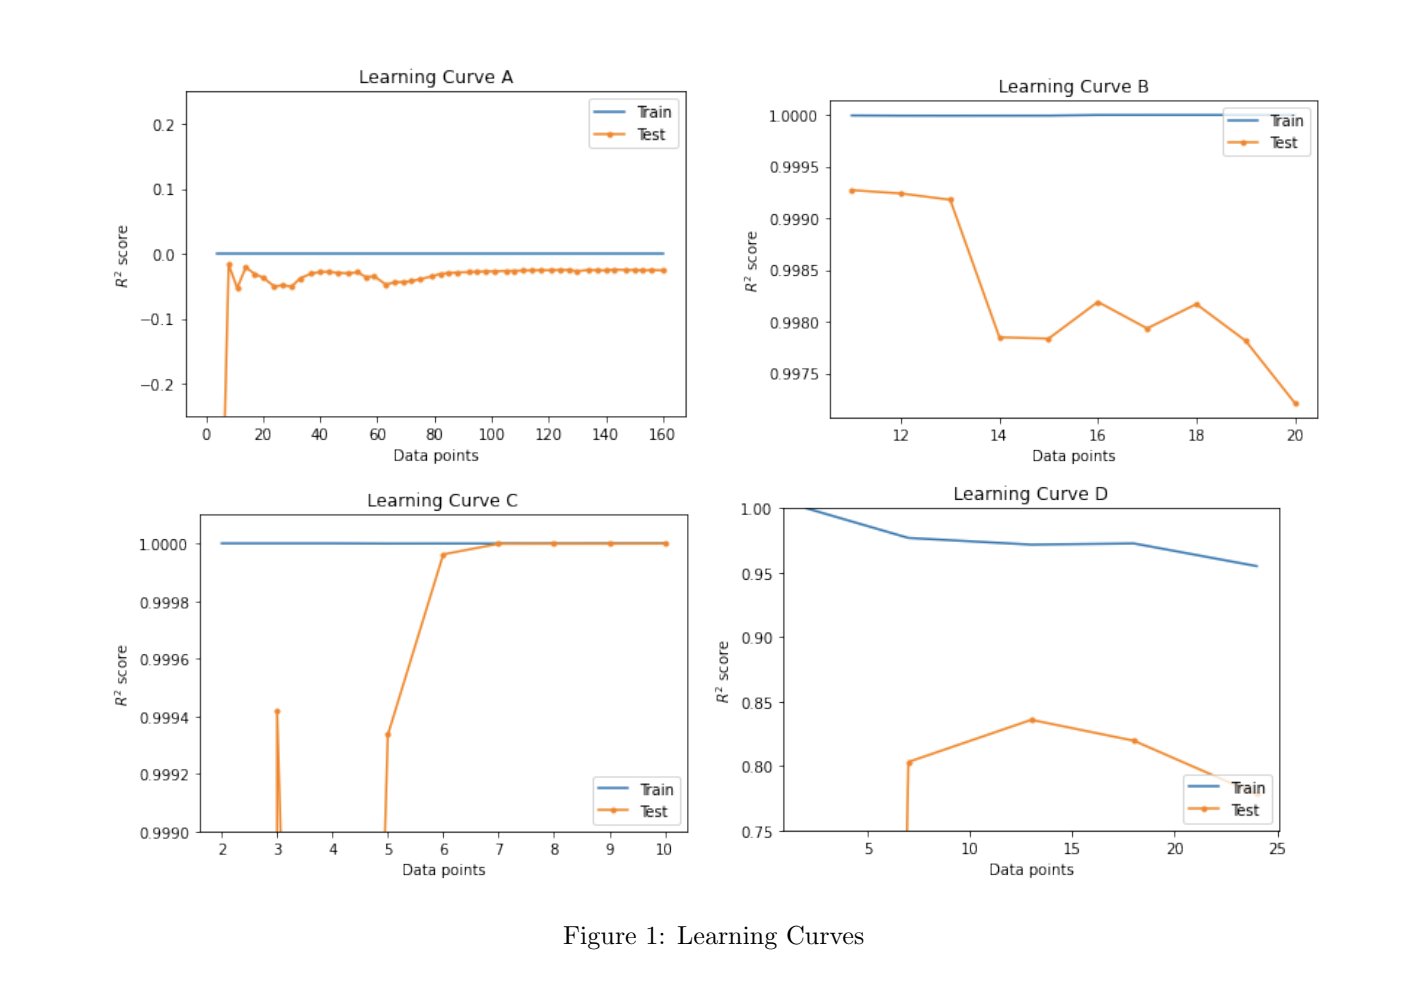



**Analysis of candidate model performance**


As per the provided learning curves (A, B, C, and D), we can make the following observations:

* **Learning Curve A:** Both training and test scores curved at a relatively low level. This suggests that the model is underfitting, meaning it's unable to process the hidden patterns in the data.

  Given the desired R² score of 0.9 or above, For this model we can follow the below approaches

     **1) Increase model complexity:** We can use a bit more complex model with more features or a higher degree of polynomial to increase the efficiency of the model.

     **2) Gather more data:** If the data used for training the model is limited, collecting additional data points can help improve the model's performance.

* **Learning Curve B:** The training score is high, but the test score is very low and plateaus early. This indicates overfitting, where the model is learning the noise things in the training data rather than the underlying patterns.

  Given the desired R² score of 0.9 or above, For this model we can follow the below approaches

     **1) Reduce model complexity:** We can simplify the model by removing additional noisy features

     **2) Gather more data:** Increasing the amount of training data can help the model generalize better.

* **Learning Curve C:** The training score is high and continues to increase slightly with more data, while the test score plateaus at a high level. This suggests a good balance between bias and variance. Hence this model is a good fit model

  Given the desired R² score of 0.9 or above, For this model we can follow the below approaches

     **1) Accept the model:** As we have good vias and variance in the model as per the learning curve, we can accept the model

* **Learning Curve D:** The training score is high, but the test score decreases with the increase in data. This might indicate an unexpected behaviour

  Given the desired R² score of 0.9 or above, For this model we can follow the below approaches

     **1) Investigate data quality:** In this model, we have to check the outliers, missing data or unwanted data and analyse the quality of data we are using.

     **2) Try different models:** Working with other algorithms or models which yields high performance might be one of the solutions.


**Problem 5: Validation Curves** (Refer to PDF)

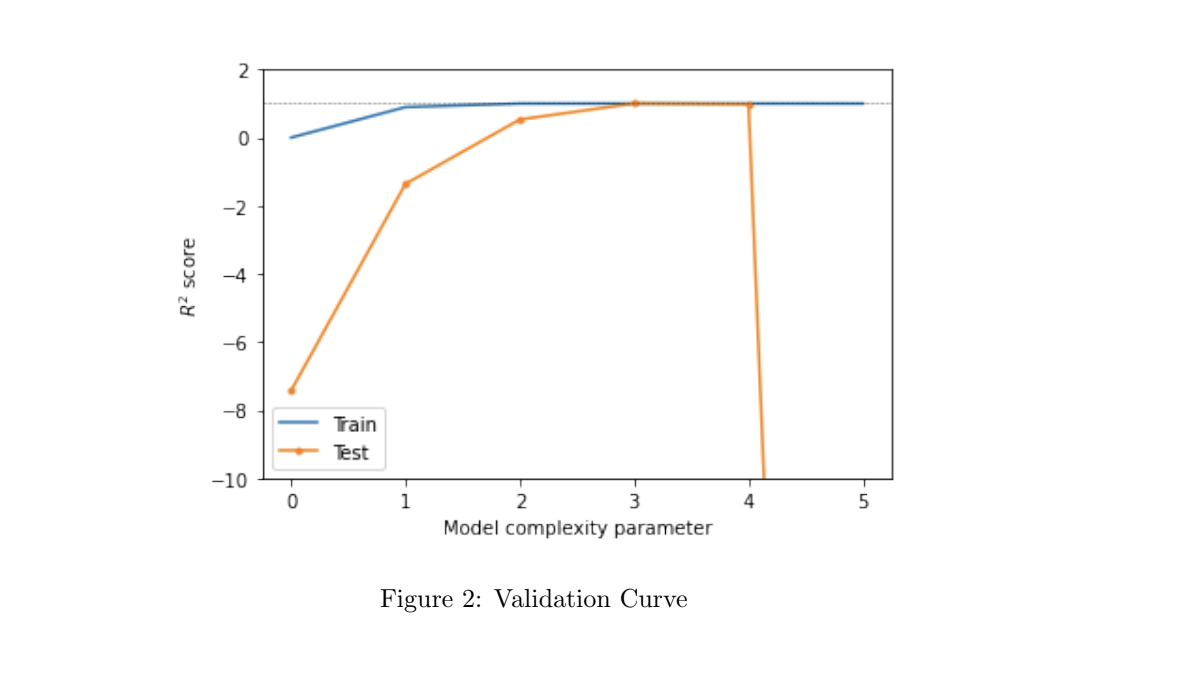

The graph shows how a model performs as you adjust a Hyperparameter called C which controls the model’s complexity.

**For Training data**

The training score remains high and constant (close to 1) starting from
C=2. This indicates that the model fits the training data almost perfectly for values C≥2.

**For Testing data**

**Underfitting (C < 3):** When C is too small, the model is unable to capture the underlying patterns in the data, leading to poor performance on both training and test sets.

**Optimal Setting (C = 3):** This value represents the sweet spot where the model achieves the best balance between bias and variance, resulting in good performance on both training and test data.

**Overfitting (C > 3):** When C is too large, the model becomes overly complex and can fit the noise in the training data, leading to high performance on the training set but poor performance on the test set.

Overall, The optimal setting for C is around 3, where the test score reaches almost 1 (0.99998), reflecting the best generalization performance. Setting C outside this range leads to either underfitting (for C<2) or overfitting (for C>3).

